<center>
<img src='./img/nsidc_logo.png'/>

# **Processing Large-scale Time Series of ICESat-2 Sea Ice Height in the Cloud**

</center>

---

## **1. Tutorial Overview**

This tutorial is designed for the "DAAC data access in the cloud hands-on experience" session at the 2023 NSIDC DAAC [User Working Group (UWG)](https://nsidc.org/data/data-programs/nsidc-daac/about-daac#anchor-2) Meeting. 

The NSIDC DAAC archives and distributes Daily and Monthly Gridded [Sea Ice Freeboard (ATL20)](https://nsidc.org/data/atl20) and [Polar Sea Surface Height Anomaly (ATL21)](https://nsidc.org/data/atl21) data sets from the ICESat-2 Mission, derived from the lower level [ATL10](https://nsidc.org/data/atl10) data set. However, we may want these lower level point data to be gridded and averaged at a weekly cadence, or using a different projection or other gridding parameters. 

This tutorial session is in two parts: 
* We will first guide you through this Jupyter Notebook running in the AWS `us-west-2` region, where data are hosted in the NASA Earthdata Cloud. The notebook utilizes several libraries to performantly search, access, read, and grid the data including `earthaccess`, `h5coro`, and `geopandas`.

* This notebook will focus on the Ross Sea, Antarctica. But let’s say we want to scale this analysis to the entire continent. In the second portion, we will present how to scale and run this same workflow from a script (see [workflow.py](./h5cloud/workflow.py) in the `h5cloud` folder within this notebook's directory) that can be run from your laptop, using [Coiled](https://www.coiled.io/). 

### **Credits**

The notebook was created by Andy Barrett and Luis Lopez of NSIDC.

For questions regarding the notebook, or to report problems, please create a new issue in the [NSIDC-Data-Tutorials repo](https://github.com/nsidc/NSIDC-Data-Tutorials/issues).

### **Learning Objectives**

By the end of this demonstration you will be able to:  
1. Use `earthaccess` to authenticate with Earthdata Login, search for ICESat-2 data using spatial and temporal filters, and directly access files in the cloud.
2. Open data granules using `h5coro` to efficiently read HDF5 data from the NSIDC DAAC S3 bucket.
3. Load data into a geopandas.DataFrame containing geodetic coordinates, ancillary variables, and date/time converted from ATLAS Epoch.
4. Grid track data to EASE-Grid v2 6.25 km projected grid using drop-in-the-bucket resampling. 
5. Calculate mean statistics and assign aggregated data to grid cells. 
5. Visualize aggregated sea ice height data on a map.

### **Prerequisites**

1. We are running this notebook in the [CryoCloud](https://book.cryointhecloud.com/intro.html) JupyterHub. For more information, see the CryoCloud [Getting Started](https://book.cryointhecloud.com/content/Getting_Started.html) documentation.
**It is advised that you use at least a 16GB instance for this notebook.** 
2. An Earthdata Login is required for data access. If you don't have one, you can register for one [here](https://urs.earthdata.nasa.gov/).
3. It is recommended that you create a .netrc file that contains your Earthdata Login credentials, stored in your home directory. If you do not have a .netrc file, `earthaccess` will prompt you to enter your Earthdata Login username and password.

### **Example of end product** 
At the end of this tutorial, the following figure will be generated, demonstrating a year's worth of ATL10 Sea Ice Freeboard height data gridded over the Ross Sea, Antarctica:
<center>
<img src='./img/icesat2.atl10.gridded.count_segments.ross_sea.png'/>
</center>

### **Time requirement**

Allow approximately 40 minutes to complete this tutorial.

## **2. Tutorial steps**

### Installing the latest version of earthaccess

The CryoCloud environment currently does not have the latest `earthaccess` version installed, along with new features in `h5coro` that are not yet released, so we will first manually install those below:

In [2]:
%%capture
# suppress install outputs

!pip uninstall -y earthaccess h5coro
!pip install earthaccess==0.6.1

# h5coro has new features that we need that are not released
!pip install git+https://github.com/ICESat2-SlideRule/h5coro.git@main

**NOTE**: Restart the kernel and clean output after running the cell above.

### **Import Packages**

In [3]:
# To force use of shapely
import os
os.environ['USE_PYGEOS'] = '0'

# For searching NASA data
import earthaccess

# For reading data, analysis and plotting
import numpy as np
import pandas as pd

# For resampling
from affine import Affine

# For plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from h5cloud.read_atl10 import read_atl10

print(f"earthaccess: {earthaccess.__version__}")

earthaccess: 0.6.1


### Authenticate

We need to authenticate and get AWS token

In [4]:
auth = earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
No .netrc found in /home/jovyan


Enter your Earthdata Login username:  amy.steiker
Enter your Earthdata password:  ········


You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/06/2023
Using user provided credentials for EDL


### **Search for ICESat-2 ATL10 data**

We use `earthaccess` to search CMR for granules in the region of interest for the time period of interest.  

The region is set by name below.  Currently, we have two options: the Ross Sea, and the Southern Ocean and adjoining seas.

The range of dates is set by assigning a start year and end year to `year_begin` and `year_end`.  Setting `year_begin` and `year_end` to the same year retreives data for one year.

In [5]:
# To avoid copying and pasting region tuples
region = "Ross Sea"  # Set region to "Ross Sea" for just Ross Sea or "Antarctica" for southern ocean 
ross_sea = (-180, -78, -160, -74)
antarctic = (-180, -90, 180, -60)
this_region = antarctic if region == "Antarctica" else ross_sea

year_begin = 2019
year_end = 2019

In [6]:
atl10 = {}
total_results = 0
approx_size = 0

for year in range(year_begin, year_end+1):
    
    print(f"Searching year {year} ...")
    granules = earthaccess.search_data(
        short_name = 'ATL10',
        version = '006',
        cloud_hosted = True,
        bounding_box = this_region,
        temporal = (f'{year}-09-01',f'{year}-09-30'),
    )
    total_results += len(granules)
    approx_size += sum([g.size() for g in granules])
    atl10[str(year)] = granules
print(f"Total retrieved: {total_results}, approx size: {round(approx_size, 2)} MB")

Searching year 2019 ...
Granules found: 59
Total retrieved: 59, approx size: 4711.89 MB


### Access the Granules

Because the CryoCloud is hub is running on servers in AWS region `us-west-2`, which is the same region as the NASA Earthdata Cloud, granules can be accessed directly without having to download the files first.  This is analogous to how you would work with files on your local filesystem.  However, _under the hood_ there are differences.

Initially, we load data for each year into a `geopandas.DataFrame`.  `geopandas` is an extension of the `pandas` package.  `pandas` is designed to work with `tabular` data - _think data you might put into a spreadsheet_.  `geopandas`, extends `pandas` to work with geospatial data by adding geometries (points, lines and polygons) and a coordinate reference system (CRS), so that data in each row is associated with a geospatial feature located on Earth.  ICESat-2 track data is well suited to the DataFrame data model because data are related to points or segments.  Once data is in a `geopandas.DataFrame`, the data can be reprojected and queried using methods you may be used to using in a GIS.

#### Read data into `geopandas.DataFrame`

The first step is to read the data and put it into a Dataframe.  We use `h5coro`, which is a package developed by the SlideRule project to efficiently read HDF5 files in the cloud.  Recall from the Cloud Optimized Format presentation, the HDF5 format and the HDF5 library for reading and writing those files are not well suited to accessing data in the cloud.  `h5coro` was developed to solve some of the problems related to HDF5 format and tools.  Using `h5coro` with `dask`, a python package for parallel processing on multicore local machines and distributed cluster in the cloud, reading data from ATL10 files is 5x faster than using the `h5py` package, an HDF5 reader that uses the HDF5 library.

The code to read the data is long, so we have created the `read_atl10` function and put it in a module.  The function is imported into this notebook.  If your are interested, take a look at `read_atl10` in [`read_atl10.py`](./h5cloud/read_atl10.py).  The main features of the function are briefly described here.

We follow the processing steps for ATL20 to generate our freeboard grids.  For each grid cell that contain one or more freeboard segments, a grid cell mean freeboard is calculated as a mean of `gtx/freeboard_segment/beam_fb_height` from ATL10, weighted by segment length `gtx/freeboard_segment/heights/height_segment_length_seg`.  To resample segments to grid cells, we also need the geodetic coordinates for each segment in `gtx/freeboard_segment/latitude` and `gtx/freeboard_segment/longitude`. As an additional locator, we also read `gtx/freeboard_segment/delta_time`.  `gtx` is the beam number.

In addition to the segment data, we also need some ancillary data from each file.  In ATL20 gridded freeboards are calculated using only the _strong beams_ of each beam pair.  Which of the six beams are strong and which are weak depends on the orientation of the ICESat-2 satellite.  Satellite orientation is given in the `orbit_info/sc_orient` dataset.  We also need to read the Atlas Standard Data Product Epoch that is stored in `ancillary_data/atlas_sdp_gps_epoch` to convert `delta_time` from seconds since launch to date and time.

```{note}
There are three beam pairs numbered 1, 2 and 3.  Each of these beam pairs has a left and right beam.  Beams are numbered `gt1l` and `gt1r`, `gt2l` and `gt2r`, and `gt3l` and `gt3r`.  Depending on the orientation of the ICESat-2 satellite, left beams or right beams are the _strong beams_.    The orientation can be _forward_ or _backward_, or _transition_.  We only use data in forward or backward orientations.
```

The datasets containing segment data are stored in the `DATASETS` constant, which is a python `list`, in `reader.py`.  If you want additional or different datasets, you can modify this list. See [NSIDC DAAC's ATL10 User Guide](https://nsidc.org/sites/default/files/documents/user-guide/atl10-v006-userguide.pdf) and [ATL10 Data Dictionary](https://nsidc.org/sites/default/files/documents/technical-reference/icesat2_atl10_data_dict_v006.pdf) for detailed descriptions.  

A ATL10 file is read using the function `read_atl10`. This function encapsulates opening an HDF5 file and reading the datasets using `h5coro`, and then creating a `geopandas.DataFrame` containing the data.  We parallelize the reading of all files in a year using `pqdm`, so files are read using different processors.  File for a given year are then concatenated into a single dataframe.

In [7]:
%%time

env = "cloud" # or local

if env == "local":
    files = [g.data_links(access="out_of_region")[0] for g in atl10["2019"]]
    cred = auth.token['access_token']
else:
    files = [g.data_links(access="direct")[0].replace("s3://", "") for g in granules]
    aws_credentials = earthaccess.get_s3_credentials("NSIDC")
    cred = {
      "aws_access_key_id": aws_credentials["accessKeyId"],
      "aws_secret_access_key": aws_credentials["secretAccessKey"],
      "aws_session_token": aws_credentials["sessionToken"]
    }
tracks = read_atl10(files, executors=4, environment=env, credentials=cred)

QUEUEING TASKS | :   0%|          | 0/59 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/59 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/59 [00:00<?, ?it/s]

CPU times: user 2min 6s, sys: 45.7 s, total: 2min 51s
Wall time: 1min 34s


In [8]:
tracks

,delta_time,seg_dist_x,height_segment_length_seg,beam_fb_height,height_segment_type,beam,geometry
1831,2019-09-01 11:10:21,2.720752e+07,20.290331,0.253510,1,gt1l,POINT (11.39429 -64.01932)
1832,2019-09-01 11:10:21,2.720753e+07,19.569931,0.265972,1,gt1l,POINT (11.39427 -64.01942)
1833,2019-09-01 11:10:21,2.720754e+07,16.069815,0.276316,1,gt1l,POINT (11.39426 -64.01948)
1834,2019-09-01 11:10:21,2.720755e+07,14.670819,0.303078,1,gt1l,POINT (11.39424 -64.01954)
1835,2019-09-01 11:10:21,2.720755e+07,14.671224,0.324290,1,gt1l,POINT (11.39423 -64.01960)
...,...,...,...,...,...,...,...
87822,2019-09-29 21:27:03,3.353085e+07,33.309284,0.078756,1,gt3r,POINT (24.31374 -59.33261)
87823,2019-09-29 21:27:03,3.353087e+07,41.701126,0.142241,9,gt3r,POINT (24.31370 -59.33242)
87824,2019-09-29 21:27:03,3.353090e+07,62.743610,0.116470,9,gt3r,POINT (24.31366 -59.33221)
87825,2019-09-29 21:27:03,3.353096e+07,144.139648,0.188011,1,gt3r,POINT (24.31354 -59.33160)


## Grid the track data

The resampling and calculation of statistics follows the processing steps described in the ATL20 - Gridded Sea Ice Freeboard - ATBD but gridding to a EASE-Grid v2 6.25 km grid.  Any projected coordinate system or grid could be chosen.  The procedure could be modified with extra QC steps or modifications.  **The world is your oyster - or [Aplacophoran](https://antarcticsun.usap.gov/science/4447/)**.

The processing steps are:

- remove non-ice and low quality segments 
- resample freeboard segments to a grid
- calculate aggregate statistics
    + mean segment length
    + segment count
    + length weighted mean freeboard
    + length weighted standard deviation of freeboard
    
### Resample Freeboard Segments to a Grid

Following the ATL20 ATBD, we will use a _drop-in-the-bucket_ resampling scheme.  This is simple and relatively easy to implement.  More complex resampling schemes could be substituted.

To demonstrate resampling we will resample freeboard segments to WGS84 / NSIDC EASE-Grid v2.0 South with a grid resolution of 6.25 km.  The EPSG code for the WGS84 / NSIDC EASE-Grid South coordinate reference system is [6932](https://epsg.org/crs_6932/WGS-84-NSIDC-EASE-Grid-2-0-South.html).

We will use the standard 6.25 km grid.  To define the grid, we need the grid dimensions (nrows and ncols), the x and y projected coordinates of the upper-left corner of the upper-left grid cell, and the height and width of the grid cells in the same units as the projected coordinates.  In this case, the units are meters.

In [9]:
easegrid2_epsg = 6932

# nrow = 2880
# ncol = 2880
# upper_left_x = -9000000.0
# upper_left_y = 9000000.0
# width = 6250.0
# height = -6250.0

nrow = 151
ncol = 147
width = 10000.0
height = -10000.0
upper_left_x = -1040000.0
upper_left_y = -560000.0

map_extent = [upper_left_x, (upper_left_x + (ncol*width)), (upper_left_y + (nrow*height)), upper_left_y]

The first step is to reproject the points from geodetic coordinates (latitude and longitude) to projected coordinates (x, y).  Because the data are in a `geopandas.DataFrame` we can use the `to_crs` method.  This takes an EPSG code either as a numeric value (`6932`) or as a string (`"EPSG:6932"`).

You can see that the `POINT` objects in the `geometry` have changed from having latitudes and longitudes as coordinates to x and y in meters.

In [10]:
%%time
tracks = tracks.to_crs(easegrid2_epsg)
tracks.head()

CPU times: user 14.3 s, sys: 1.51 s, total: 15.8 s
Wall time: 15.8 s


,delta_time,seg_dist_x,height_segment_length_seg,beam_fb_height,height_segment_type,beam,geometry
1831,2019-09-01 11:10:21,2.720752e+07,20.290331,0.253510,1,gt1l,POINT (568023.081 2818528.976)
1832,2019-09-01 11:10:21,2.720753e+07,19.569931,0.265972,1,gt1l,POINT (568019.787 2818518.673)
1833,2019-09-01 11:10:21,2.720754e+07,16.069815,0.276316,1,gt1l,POINT (568017.576 2818511.765)
1834,2019-09-01 11:10:21,2.720755e+07,14.670819,0.303078,1,gt1l,POINT (568015.636 2818505.708)
1835,2019-09-01 11:10:21,2.720755e+07,14.671224,0.324290,1,gt1l,POINT (568013.520 2818499.103)


A _Drop-in-the-Bucket_ resampling scheme collects points into the grid cells that they intersect with, and then calculates aggregate statistics for each grid cell using attributes associated with those points.

We'll find the grid cell that contains each segment by calculating the row and column coordinates for each segment from the projected coordinates.  This is done by creating an _Affine_ transformation matrix for the grid.  The Affine matrix is just a matrix representation of the algebraic expressions to convert row and column indices of the grid to projected coordinates.  The equations below give the forward transformation from `(row, col)` to `(x, y)`. 

$$
x = width * col + upper\_left\_x \\
y = height * row + upper\_left\_y
$$

These are expressed in matrix form:

$$
\begin{bmatrix}
x \\
y \\
0
\end{bmatrix} = 
\begin{bmatrix}
a & 0 & c \\
0 & d & e \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
col \\
row \\
1
\end{bmatrix}
$$

where $a$ is $\mathsf{width}$, $c$ is $\mathsf{upper\_left\_x}$, $d$ is $height$, and $e$ is $upper\_left\_y$.

```{note}
The projected coordinate system we are using is a cartesian plane with the origin at the South Pole.  The `x` coordinates increase to the right, and `y` coordinates increase up.  For raster data, which includes grids and images, have the origin at the upper-left corner of the grid.  Column indices increase from right to left, and row indices increase from top to bottom.
```

We use the `affine` package to create a forward transformation matrix (`fwd`) using the grid parameters above.  To transform `(x, y)` projected coordinates to `(row, col)`, we can calculate the reverse transformation matrix using `~fwd`.

`(row, col)` coordinates are still rational numbers.  We want an integer row and column indices for grid cells.  We can use the `floor` function to get integers.  `row` and `column` indices are zero based.

We want to be able to leverage the `geopandas.Dataframe.groupby` functionality to collect points into grid cells, so we need a unique identifier to group the data.  We can calculate a unique cell index from `row` and `column` indices as follows:

$$
cell\_index = row * ncol + col
$$

This is encapsulated in the function `get_grid_index`.  This function is then applied to the `geometry` of tracks.

In [11]:
def get_grid_index(xy):
    geotransform = (upper_left_x, width, 0., upper_left_y, 0., height)
    fwd = Affine.from_gdal(*geotransform)
    col, row = ~fwd * xy
    return (np.floor(row) * ncol) + np.floor(col)

In [12]:
%%time
tracks["grid_index"] = [get_grid_index((x, y)) for x, y in zip(tracks.geometry.x, tracks.geometry.y)]
tracks.head()

CPU times: user 1min 41s, sys: 468 ms, total: 1min 42s
Wall time: 1min 42s


,delta_time,seg_dist_x,height_segment_length_seg,beam_fb_height,height_segment_type,beam,geometry,grid_index
1831,2019-09-01 11:10:21,2.720752e+07,20.290331,0.253510,1,gt1l,POINT (568023.081 2818528.976),-49526.0
1832,2019-09-01 11:10:21,2.720753e+07,19.569931,0.265972,1,gt1l,POINT (568019.787 2818518.673),-49526.0
1833,2019-09-01 11:10:21,2.720754e+07,16.069815,0.276316,1,gt1l,POINT (568017.576 2818511.765),-49526.0
1834,2019-09-01 11:10:21,2.720755e+07,14.670819,0.303078,1,gt1l,POINT (568015.636 2818505.708),-49526.0
1835,2019-09-01 11:10:21,2.720755e+07,14.671224,0.324290,1,gt1l,POINT (568013.520 2818499.103),-49526.0


### Calculate grid cell mean statistics

We calculate four statistics for grid cells that contain segments.

#### Grid Cell Mean Segment Length $\bar{L}$

$$
\bar{L}(x, y, D) = \frac{\sum L_i}{N}
$$

where $L_i$ is `/gtx/freeboard_beam_segment/height_segments/height_segment_length_seg`, $x$ and $y$ are projected coordinates for grid centers, and $D$ is day. 

#### Grid Cell Mean Freeboard $\bar{h}$

$$
\bar{h}(x, y, D) = \frac{\sum L_i h_i}{\sum L_i}
$$

where $h_i$ is `gtx/freeboard_beam_segment/beam_freeboard/beam_fb_height`.

#### Grid Cell Standard Deviation of Freeboard $\sigma^2 (x, y, D)$

$$
\sigma^2 (x, y, D) = \frac{\sum L_i (h_i)^2}{\sum L_i} - \bar{h}^2 (x, y, D)
$$

The functions to calculate these statistics are given below.  These functions are applied to the grouped data.  The `geopandas.apply` method only accepts a single method when operating on multiple columns in a dataframe.  We could just have multiple calls for each aggregating function.  However, we can collect the individual aggregating functions into a single function and pass that to the `apply` method. 

In [13]:
def mean_segment_length(df):
    """Returns mean segment length"""
    return df["height_segment_length_seg"].mean()


def mean_freeboard(df):
    """Returns length weighted mean freeboard"""
    return (df.beam_fb_height * df.height_segment_length_seg).sum() / df.height_segment_length_seg.sum()


def stdev_freeboard(df):
    """Returns weighted standard deviation of freeboard"""
    hmean = mean_freeboard(df)
    stdev = (df.beam_fb_height**2 * df.height_segment_length_seg).sum() / df.height_segment_length_seg.sum()
    return stdev - hmean**2


def count_segments(df):
    """Number of segments in grid cell"""
    return df.beam_fb_height.count()


def all_funcs(x):
    """Wrapper that allows all the aggregation functions to be applied at once"""
    funcs = {
        mean_segment_length.__name__: mean_segment_length(x),  #__name__ gets the name of a function
        mean_freeboard.__name__: mean_freeboard(x),
        stdev_freeboard.__name__: stdev_freeboard(x),
        count_segments.__name__: count_segments(x),
    }
    # `apply` is expected to return a series or a scaler so we collect the results
    # into a series indexed by aggregating function name
    return pd.Series(funcs, index=funcs.keys())

#### Testing the functions

It is always a good idea to test your code.  Below are some test data and expected results.  The functions are tested on `test_df`.  We then use `pandas.testing.assert_frame_equal` to check that the result and expected dataframes are the same.  In this case we are only interested getting the same values, so we do not check the names or datatypes. 

In [14]:
test_df = pd.DataFrame(
    {
        'grid_index': [1, 1, 1, 2, 2, 2, 2],
        "height_segment_length_seg": [1.2, 1.1, 0.7, 2.3, 1.5, .9, 1.],
        "beam_fb_height": [0., 0.2, 0.5, 1.1, 2., .9, 1.5],        
    }
)
expected = pd.DataFrame(
    {
        "mean_segment_length": [1.0, 1.425],
        "mean_freeboard": [0.19000000000000003, 1.375438596491228],
        "stdev_freeboard": [0.03689999999999998, 0.17167743921206569],
        "count_segments": [3, 4],
    },
    index = [1, 2]
)

In [15]:
result = test_df.groupby("grid_index").apply(all_funcs)
result

,mean_segment_length,mean_freeboard,stdev_freeboard,count_segments
grid_index,,,,
1,1.000,0.190000,0.036900,3.0
2,1.425,1.375439,0.171677,4.0


In [16]:
pd.testing.assert_frame_equal(expected, result, check_names=False, check_dtype=False)

Now that we have functions that work we can apply them to the real data.

In [17]:
%%time
aggregated_data = tracks.groupby("grid_index").apply(all_funcs)
aggregated_data

CPU times: user 22.7 s, sys: 368 ms, total: 23.1 s
Wall time: 23.1 s


,mean_segment_length,mean_freeboard,stdev_freeboard,count_segments
grid_index,,,,
-63836.0,35.544930,0.461877,0.048001,394.0
-63689.0,20.859682,0.529577,0.048061,1364.0
-63688.0,17.013283,0.580957,0.046754,203.0
-63542.0,16.194633,0.506654,0.049144,3649.0
-63396.0,13.722307,0.563801,0.022238,299.0
...,...,...,...,...
34094.0,13.612464,0.096349,0.001544,2060.0
34212.0,66.543144,0.362712,0.031803,18.0
34240.0,12.773907,0.117769,0.001388,1698.0


### Assign aggregated data to grid cells

We now have a dataframe that contains grid cell statistics indexed by a unique array index.  We can now create a grid for each of these statistics.

The procedure is relatively straight forward.

 - Create an 1D array with the same number of elements as cells in our grid.
 - Use the `grid_index` of the dataframe as an array index to assign values to grid cells, where we have data.
 - Reshape the grid to the dimension of the grid.
 
We can encapsulate this in a `series_to_grid` function.

In [18]:
def series_to_grid(series, nrow, ncol):
    """Converts a geopandas.Series to a grid using the index"""
    these_points = (series.index >= 0) & (series.index < (nrow*ncol - 1))
    
    array_index = series[these_points].index.values.astype(int)  # the array index must be an integer
    
    vector = np.full(nrow*ncol, np.nan)
    vector[array_index] = series[these_points]
    return vector.reshape(nrow, ncol)

In [19]:
%%time
grids = {name: series_to_grid(values, nrow, ncol) for name, values in aggregated_data.items()}

CPU times: user 2.67 ms, sys: 0 ns, total: 2.67 ms
Wall time: 2.3 ms


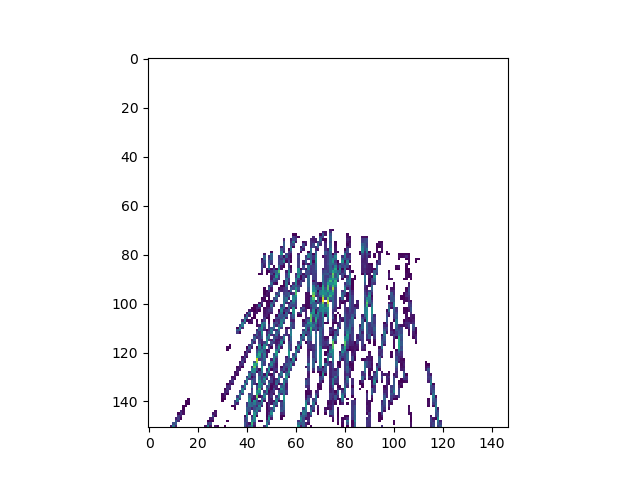

In [20]:
%matplotlib widget
plt.imshow(grids['count_segments'], interpolation='none')
plt.show()

## Plot data on a map

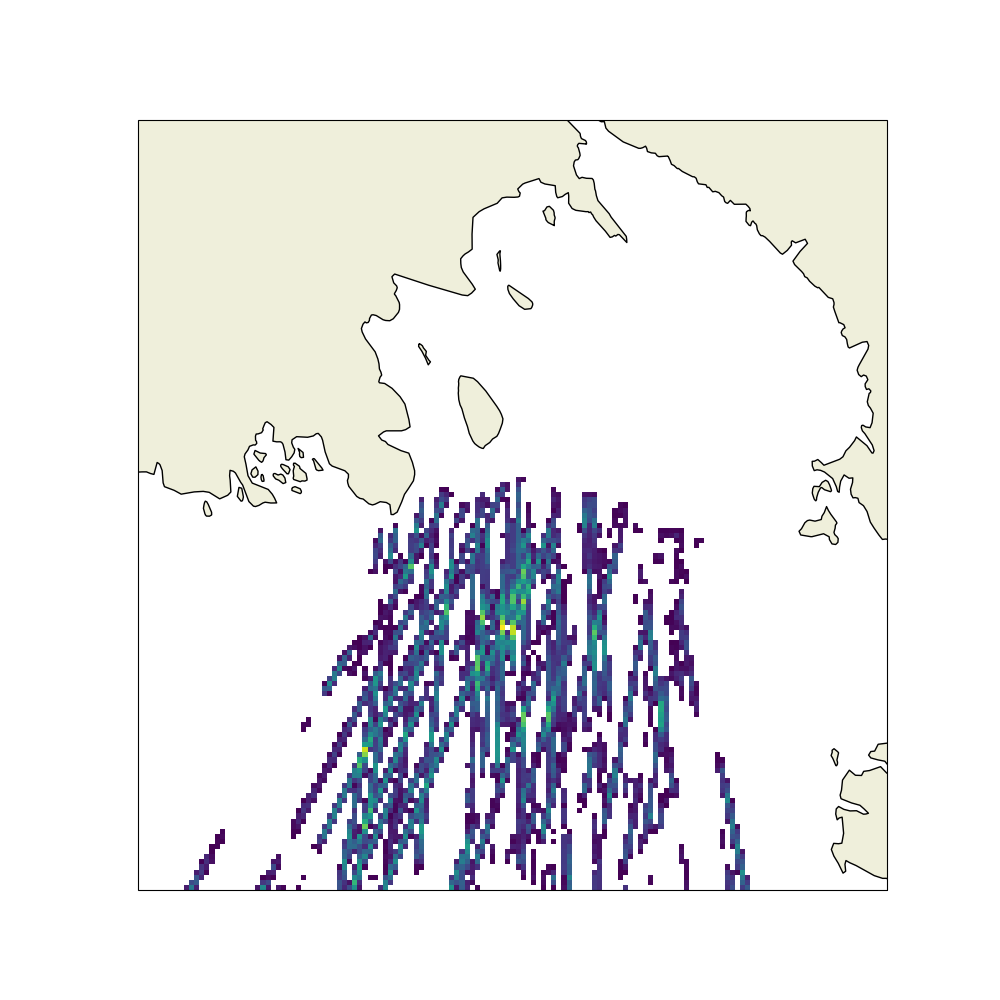

In [21]:
#proj = EASEGrid2South()
plt.close("all")
proj = ccrs.LambertAzimuthalEqualArea(central_latitude=-90)

test_extent = [-3000000.0, 3000000.0, -3000000.0, 3000000.0]
#np.array(map_extent)+np.array([-1e6,-1e6,1e6,1e6])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=proj)
ax.set_extent(map_extent, proj)
ax.add_feature(cfeature.LAND)
ax.coastlines()

plt.imshow(grids['count_segments'], interpolation='none', extent=map_extent)
#ax.set_extent(

## Appendix

### Get grid parameters for Ross Sea region

In [35]:
# Import GeoJSON of Ross Sea - this is very approximate
import geopandas as gpd

ross_sea_gdf = gpd.read_file("ross_sea.json")
bounds = ross_sea_gdf.to_crs(easegrid2_epsg).bounds.values

In [36]:
# Calculate parameters for a grid with resolution that covers region
resolution = 10000.
minx, miny, maxx, maxy = [func(bound/resolution) * resolution for bound, func in zip(list(bounds), [np.floor, np.floor, np.ceil, np.ceil])][0]

grid_extent_x = maxx - minx
grid_extent_y = maxy - miny

width = height = resolution

ncol = grid_extent_x / width
nrow = grid_extent_y / height

upper_left_x = minx
upper_left_y = maxy

print(f"nrow = {int(nrow)}")
print(f"ncol = {int(ncol)}")
print(f"width = {width}")
print(f"height = -{height}")
print(f"upper_left_x = {upper_left_x}")
print(f"upper_left_y = {upper_left_y}")
      

nrow = 151
ncol = 147
width = 10000.0
height = -10000.0
upper_left_x = -1040000.0
upper_left_y = -560000.0


In [37]:
# from cartopy.crs import AzimuthalEquidistant

# class EASEGrid2South(AzimuthalEquidistant):
    
#     def __init__(self):
#         super(EASEGrid2South, self).__init__(central_longitude=0.0, central_latitude=-90.0,
#                  false_easting=0.0, false_northing=0.0,
#                  globe=None)
        
#         self._bounds = [-9000000.0, -9000000.0, 9000000.0, 9000000.0]
#         self._x_limits = self._bounds[0], self._bounds[2]
#         self._y_limits = self._bounds[1], self._bounds[3]
        

#     @property
#     def bounds(self):
#         return self._bounds
    
#     @property
#     def threshold(self):
#         return 1e5

#     @property
#     def x_limits(self):
#         return self._x_limits

#     @property
#     def y_limits(self):
#         return self._y_limits
